In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy.special import sph_harm

(28872,) 32451 2324.4214117484066 1505.0


/var/folders/w1/lh3h4s7d5g10rdlfj4h0mshw0000gn/T/ipykernel_5640/4044505290.py:16: RuntimeWarning: divide by zero encountered in log10
  np.log10(pix_map),


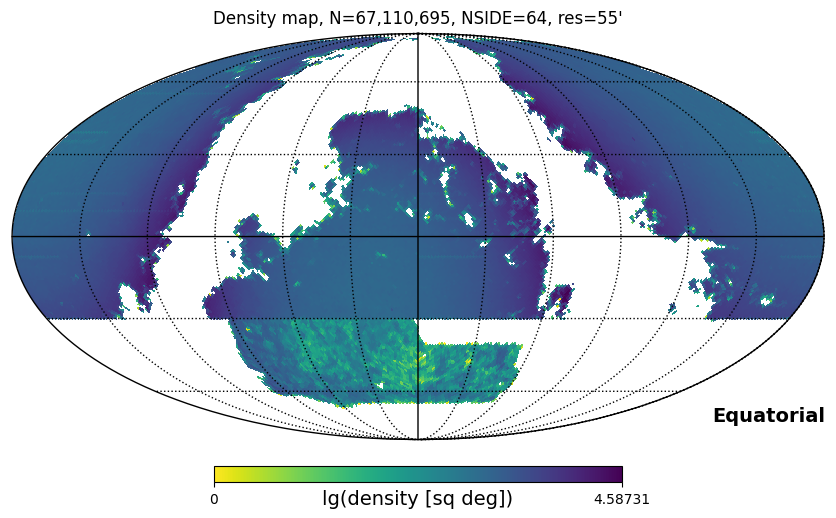

In [8]:
nside = 64
resolution_arcmin = hp.nside2resol(nside, arcmin=True)
area_sqdeg = hp.nside2pixarea(nside, degrees=True)

df = pd.read_parquet('data/stars.parquet', columns=['ps1_ra', 'ps1_dec', 'des_ra', 'des_dec'])
ra = np.where(df['ps1_ra'].isnull(), df['des_ra'], df['ps1_ra'])
dec = np.where(df['ps1_dec'].isnull(), df['des_dec'], df['ps1_dec'])
healpix = hp.ang2pix(nside, ra, dec, lonlat=True)
del df, ra, dec
pix, counts = np.unique(healpix, return_counts=True)
pix_map = np.zeros(hp.nside2npix(nside), dtype=int)
pix_map[pix] = counts / area_sqdeg
print(pix.shape, counts.max(), counts.mean(), np.median(counts))

hp.mollview(
    np.log10(pix_map),
    title=f"Density map, N={healpix.size:,d}, NSIDE={nside}, res={resolution_arcmin:.0f}'",
    cmap='viridis_r',
    bgcolor='white',
    unit='lg(density [sq deg])',
    coord='C',
    flip='astro',
)
hp.graticule()

In [ ]:
nside = 32
resolution_arcmin = hp.nside2resol(nside, arcmin=True)
area_sqdeg = hp.nside2pixarea(nside, degrees=True)

df = pd.read_parquet('data/ps1_gaia.parquet', columns=['ps1_ra', 'ps1_dec', 'gaia_ra', 'gaia_dec',
                                                       'ps1_mag_g', 'ps1_magerr_g', 'ps1_mag_r', 'ps1_magerr_r',
                                                       'gaia_mag_G', 'gaia_magerr_G'])
support_band = 'r'
ra, dec = df[f'ps1_ra'].to_numpy(), df[f'ps1_dec'].to_numpy()
healpix = hp.ang2pix(nside, ra, dec, lonlat=True)
pix = np.unique(healpix)

def plot_skymap(offsets, **kwargs):
    weighted_offsets = offsets / (df[f'ps1_magerr_{support_band}']**2 + df['gaia_magerr_G']**2)
    weighted_sums = ndimage.sum_labels(
        weighted_offsets,
        labels=healpix,
        index=pix,
    )
    weights = ndimage.sum_labels(
        1.0 / (df[f'ps1_magerr_{support_band}']**2 + df['gaia_magerr_G']**2),
        labels=healpix,
        index=pix,
    )
    pix_map = np.full(hp.nside2npix(nside), np.nan)
    pix_map[pix] = weighted_sums / weights

    hp.mollview(
        pix_map,
        title=f"Density map, N={healpix.size:,d}, NSIDE={nside}, res={resolution_arcmin:.0f}'",
        cmap='viridis_r',
        bgcolor='white',
        unit=f'PS1 {support_band} - G',
        coord='C',
        flip='astro',
        **kwargs,
    )
    hp.graticule()

offset = np.array(df[f'ps1_mag_{support_band}'] - df['gaia_mag_G'])

plot_skymap(offset, min=-0.02, max=0.07)


def sph_pol(coeffs):
    coeffs = np.array(coeffs)
    assert coeffs.size > 0
    assert (np.sqrt(coeffs.size) - 1) % 1 == 0, str(coeffs.size)
    order = int(np.sqrt(coeffs.size) - 1)

    def f(ra, dec):
        theta = np.deg2rad(90 - dec)
        phi = np.deg2rad(ra)
        Y = [sph_harm(0, 0, phi, theta)]
        for l in range(1, order+1):
            for m in range(-l, l+1):
                Y.append(sph_harm(m, l, phi, theta))
        Y = np.array(Y)
        return (coeffs @ Y).real

    return f


def fit_sph_harm(ra, dec, values, order: int = 3):
    Y = sph_pol(np.ones((order + 1)**2))
    coeffs, res, rank, s = np.linalg.lstsq(Y(ra, dec)[:, None], values, rcond=None)
    return sph_pol(coeffs)


plt.figure()
f = fit_sph_harm(ra, dec, offset, order=12)
plot_skymap(offset - f(ra, dec), min=-0.02, max=0.045)


plt.figure()
plt.hist(offset, bins=np.linspace(*np.quantile(offset, [0.001, 0.999]), 100), label='original', histtype='step')
plt.hist(f(ra, dec), bins=np.linspace(*np.quantile(offset, [0.001, 0.999]), 100), label='fit', histtype='step')
plt.xlabel(f'PS1 {support_band} - G')
plt.legend()